In [16]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from tqdm import tqdm
import arviz as az
import cmdstanpy as stan
from scipy.special import expit
import pickle

In [2]:
%load_ext stanmagic

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set() 

# Import data

In [4]:
df = pd.read_csv("data_full.csv", index_col=0)
df.drop(df[(df.domain != "active.fi") | (df.n_session_done != 14)].index, inplace=True)
df

,user,domain,condition,item,success,teacher_md,learner_md,psy_md,session,is_eval,ts_display,ts_reply,n_session_done
49739,goldfish@active.fi,active.fi,ThresholdCondition,1506,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:37.666000+00:00,2020-09-30 17:51:41.042000+00:00,14
49740,goldfish@active.fi,active.fi,ThresholdCondition,190,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:42.081000+00:00,2020-09-30 17:51:43.910000+00:00,14
49741,goldfish@active.fi,active.fi,ThresholdCondition,1000,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:44.980000+00:00,2020-09-30 17:51:46.413000+00:00,14
49742,goldfish@active.fi,active.fi,ThresholdCondition,1506,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:47.476000+00:00,2020-09-30 17:51:50.206000+00:00,14
49743,goldfish@active.fi,active.fi,ThresholdCondition,190,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:51.245000+00:00,2020-09-30 17:51:53.477000+00:00,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147617,azalea@active.fi,active.fi,ThresholdCondition,179,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:21.524000+00:00,2020-10-08 05:52:31.640000+00:00,14
147618,azalea@active.fi,active.fi,ThresholdCondition,1071,False,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:32.658000+00:00,2020-10-08 05:52:45.959000+00:00,14
147619,azalea@active.fi,active.fi,ThresholdCondition,1196,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:48.143000+00:00,2020-10-08 05:52:51.527000+00:00,14
147620,azalea@active.fi,active.fi,ThresholdCondition,1282,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:52.543000+00:00,2020-10-08 05:52:56.460000+00:00,14


In [5]:
df["ts_display"] = pd.to_datetime(df["ts_display"])  # str to datetime
df["ts_reply"] = pd.to_datetime(df["ts_reply"]) 

In [6]:
# Convert timestamps into seconds
beginning_history = pd.Timestamp("1970-01-01", tz="UTC")
df["timestamp"] = (df["ts_reply"] - beginning_history).dt.total_seconds().values

In [7]:
n_u = len(df.user.unique())
n_w = len(df.item.unique())
print(f"n_u={n_u}, n_w={n_w}" )

n_u=53, n_w=1998


In [8]:
# Copy actual item ID
df["item_id"] = df.item

In [9]:
for i, i_id in enumerate(df.item_id.unique()): 
    df.loc[df.item_id == i_id, 'item'] = i

In [10]:
print(df.item.min())
print(df.item.max())

0
1997


In [11]:
n_o_by_u = np.zeros(shape=n_u, dtype=int)
for u, (user, user_df) in enumerate(df.groupby("user")):
    n_o_by_u[u] = len(user_df) - len(user_df.item.unique())
n_o = n_o_by_u.max()
print( f"n_o={n_o}")
print(f"min n_o={n_o_by_u.min()}")

n_o=1404
min n_o=1285


In [12]:
words = np.zeros(shape=(n_u, n_o), dtype=int)
delta = np.zeros(shape=(n_u, n_o))
n_rep = np.zeros(shape=(n_u, n_o), dtype=int)
y = np.zeros(shape=(n_u, n_o), dtype=int)

for u, (user, user_df) in enumerate(df.groupby("user")):
    
    user_df = user_df.sort_values(by="timestamp")
    seen = user_df.item.unique()
    words_u = user_df.item.values
    ts_u = user_df.timestamp.values
    counts = {word: -1 for word in seen}
    last_pres = {word: None for word in seen}
    n_rep_u = np.zeros(len(user_df))
    delta_u = np.zeros(n_rep_u.shape)
    for i, word in enumerate(words_u):
        ts = ts_u[i]
        n_rep_u[i] = counts[word]
        if last_pres[word] is not None:
            delta_u[i] =  ts - last_pres[word]
        counts[word] += 1
        last_pres[word] = ts
    
    to_keep = n_rep_u >= 0
    y_u = user_df.success.values[to_keep]
    n_rep_u = n_rep_u[to_keep]
    words_u = words_u[to_keep]
    delta_u = delta_u[to_keep]
    
    n_ou = n_o_by_u[u]
    n_rep[u, :n_ou] = n_rep_u
    words[u, :n_ou] = words_u
    delta[u, :n_ou] = delta_u
    y[u, :n_ou] = y_u

data = {'n_u': int(n_u), 'n_w': int(n_w),  'n_o': int(n_o), 
        'delta': delta, 
        'n_rep': n_rep, 'y': y, 
        'n_o_by_u': n_o_by_u,
        'words': words + 1} # Stan index starts from 1

# Debug using Scipy

In [118]:
def objective(param):
    words -= 1
    
    sum_ll = 0
    
    sg_w1, sg_u1, sg_theta1, sg_theta2, mu1, mu2, sg_w2, sg_u2 = param
    U1 = np.random.normal(0, sg_u1, size=n_u)
    W1 = np.random.normal(0, sg_w1, size=n_w)
    U2 = np.random.normal(0, sg_u2, size=n_u)
    W2 = np.random.normal(0, sg_w2, size=n_w)

    for u in range(n_u):
        n_ou = n_o_by_u[u];
        words_u = words[u, :n_ou];
        mu1_u = mu1 + U1[u] + W1[words_u]
        mu2_u = mu2 + U2[u] + W2[words_u]
        theta1_wu = np.random.normal(mu1_u, sg_theta1, size=n_ou)
        theta2_wu = np.random.normal(mu2_u, sg_theta2, size=n_ou)
        a = np.exp(theta1_wu)
        b = expit(theta2_wu)
        n_rep_arr = n_rep[u, :n_ou]
        delta_arr = delta[u, :n_ou]
        y_arr = y[u, :n_ou]
        exponent = - a * np.power(1-b, n_rep_arr) * delta_arr
        p_suc = np.exp(exponent)
        p = np.power(p_suc, y_arr) * np.power(1-p_suc, 1-y_arr)
        log_p = np.log(p + np.finfo(float).eps)
        sum_ll += log_p.sum()
    
    return - sum_ll

In [119]:
# Define bounds and an initial guess
bounds = [(0, None), (0, None), (0, None), (0, None), 
          (None, None), (None, None), (0, None), (0, None)]
init_guess = (0.1, 0.1, 0.1, 0.1, 0, 0, 0.1, 0.1)

# Run the optimizer
res = scipy.optimize.minimize(
    fun=objective,
    x0=init_guess,
    bounds=bounds)
res

      fun: 2117878.069156808
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.84296240e+11, -1.95367333e+11,  4.01290098e+11,  7.15525102e+10,
        3.45141176e+11, -5.09637810e+10,  1.37297387e+11, -6.77866407e+10])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 261
      nit: 3
     njev: 29
   status: 0
  success: True
        x: array([ 1.00000000e-01,  1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
        8.04231416e-10, -7.66401150e-09,  1.00000000e-01,  1.00000004e-01])

# Stan model

In [13]:
%%stan -f modelXPdata.stan -v model --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
data {
  int<lower=0> n_u;    
  int<lower=0> n_w;  
  int<lower=0> n_o;  
  real delta[n_u, n_o];
  int n_rep[n_u, n_o];
  int y[n_u, n_o];
  int words[n_u, n_o];
  int n_o_by_u[n_u];
}
transformed data {
}
parameters {
  real<lower=0> sg_u1;
  real<lower=0> sg_w1;
  real<lower=0> sg_theta1;
  real mu1;
  real<lower=0> sg_u2;
  real<lower=0> sg_w2;
  real<lower=0> sg_theta2;
  real mu2;
  
  real U1[n_u];
  real W1[n_w];
  real theta1_wu[n_u, n_o];
  real U2[n_u];
  real W2[n_w];
  real theta2_wu[n_u, n_o];
}
model {
  int n_ou;
  
  sg_w1 ~ inv_gamma(1, 1);
  sg_u1 ~ inv_gamma(1, 1);
  sg_theta1 ~ inv_gamma(1, 1);
  mu1 ~ normal(0, 10);
  U1 ~ normal(0, sg_u1);
  W1 ~ normal(0, sg_w1);
  
  sg_w2 ~ inv_gamma(1, 1);
  sg_u2 ~ inv_gamma(1, 1);
  sg_theta2 ~ inv_gamma(1, 1);
  mu2 ~ normal(0, 10);
  U2 ~ normal(0, sg_u2);
  W2 ~ normal(0, sg_w2);

  for (u in 1:n_u) {
    n_ou = n_o_by_u[u];
    vector[n_ou] a;
    vector[n_ou] b;
    vector[n_ou] rate;
    vector[n_ou] exponent;
    vector[n_ou] p;
    vector[n_ou] p_suc;
    vector[n_ou] log_p;
    vector[n_ou] y_arr;
    vector[n_ou] delta_arr;
    vector[n_ou] n_rep_arr;
    vector[n_ou] mu1_u;
    vector[n_ou] mu2_u;
    int words_u[n_ou];
    words_u = words[u, 1:n_ou];
    mu1_u = rep_vector(mu1 + U1[u], n_ou) + to_vector(W1[words_u]);
    mu2_u = rep_vector(mu2 + U2[u], n_ou) + to_vector(W2[words_u]);
    theta1_wu[u, 1:n_ou] ~ normal(mu1_u, sg_theta1);
    theta2_wu[u, 1:n_ou] ~ normal(mu2_u, sg_theta2);
    a = exp(to_vector(theta1_wu[u, 1:n_ou]));
    b = inv_logit(to_vector(theta2_wu[u, 1:n_ou]));
    n_rep_arr = to_vector(n_rep[u, 1:n_ou]);
    delta_arr = to_vector(delta[u, 1:n_ou]);
    y_arr = to_vector(y[u, 1:n_ou]);
    exponent = - a .* pow(1-b, n_rep_arr) .* delta_arr;
    p_suc = exp(exponent);
    p = pow(p_suc, y_arr) .* pow(1-p_suc, 1-y_arr);
    log_p = log(p + machine_precision());
    target += sum(log_p);
  }
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/0980e6cb-da03-43e4-8e79-7483b2158a51.cpp modelXPdata.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in model object.
Type model in a cell to see a nicely formatted code output in a notebook
     ^^^^^
Access model compile output properties
model.model_file -> Name of stan_file [modelXPdata.stan]
model.model_name -> Name of stan model [modelXPdata_model]
model.model_code -> Model code [data {   int<lower=0 ....]


In [14]:
m = stan.CmdStanModel(stan_file=model.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/modelXPdata
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/modelXPdata


# MCMC

## Run

In [126]:
trace = m.sample(data=data, show_progress="notebook")

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

## Save

In [128]:
with open("bkp_trace_xp.p", 'wb') as f:
    pickle.dump(trace, f)

## Load

In [17]:
with open("bkp_trace_xp.p", 'rb') as f:
    trace = pickle.load(f)

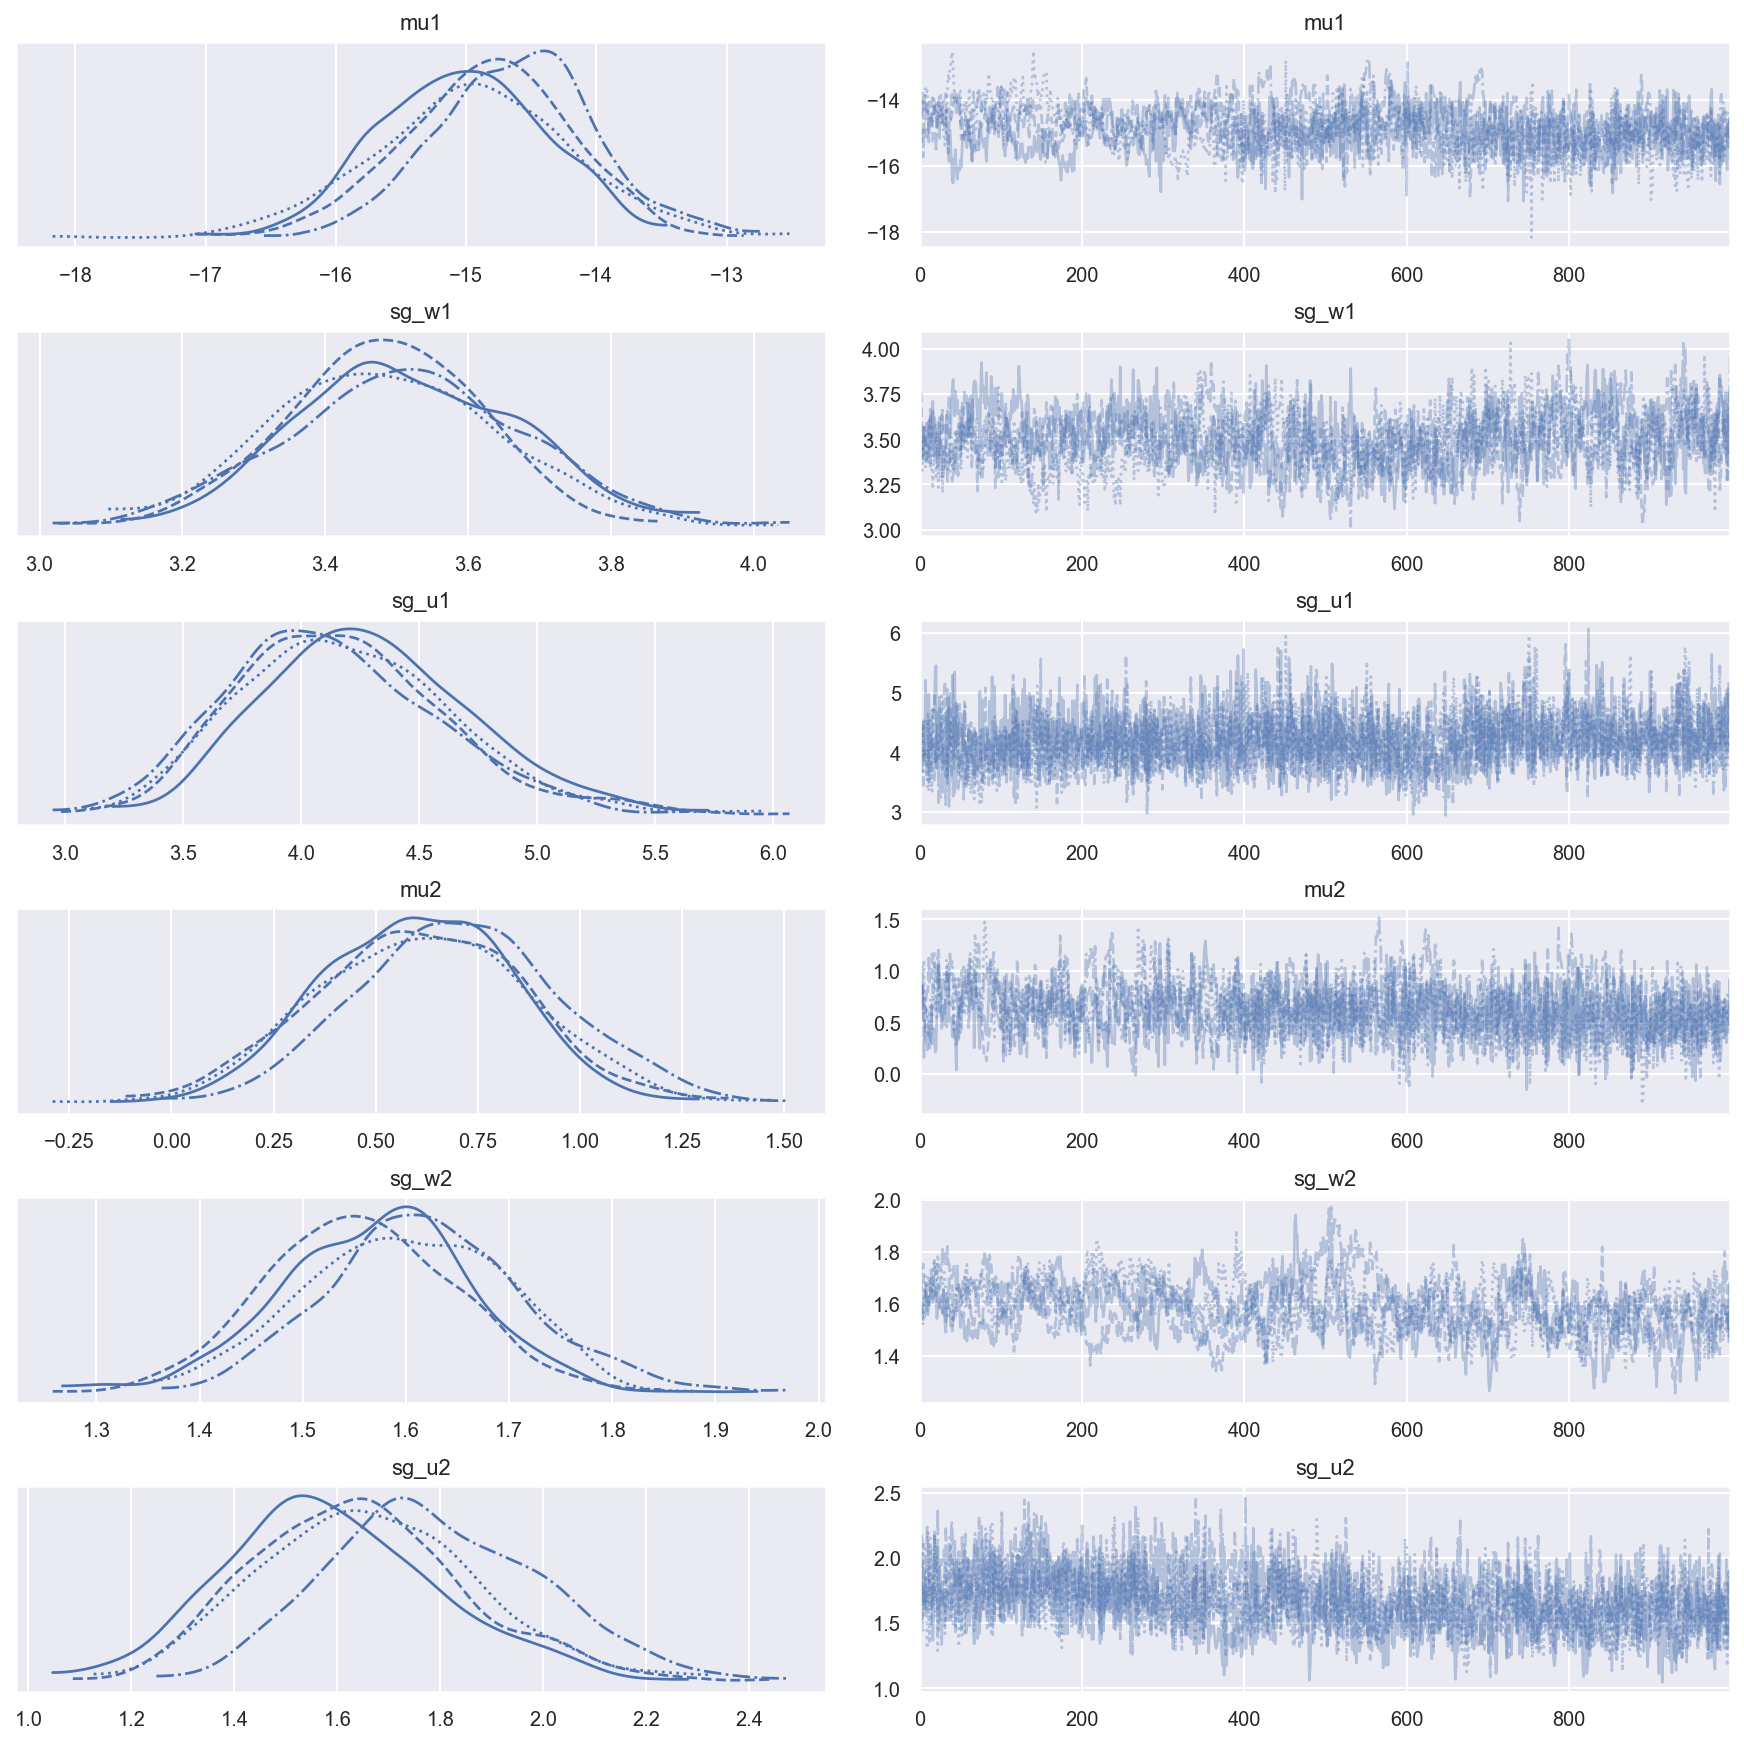

In [18]:
az.plot_trace(trace, var_names=['mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2']);

# MLE

In [19]:
%%time
mp = m.optimize(data=data, algorithm='LBFGS', seed=1)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


CPU times: user 612 ms, sys: 53.5 ms, total: 666 ms
Wall time: 1min 19s


In [20]:
for var in 'mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2':
    print(var, mp.optimized_params_dict[var])

mu1 -1.07309
sg_w1 0.000697343
sg_u1 0.247318
mu2 1.2424
sg_w2 0.000412185
sg_u2 7.64256e+16


(not very satisfying...)

# VI

In [22]:
%%time
vi = m.variational(data=data, seed=123)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


CPU times: user 11min 14s, sys: 21.2 s, total: 11min 36s
Wall time: 20min 36s


In [28]:
for var in 'mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2':
    print(var, vi.variational_params_dict[var])

mu1 -6.71199
sg_w1 0.391382
sg_u1 1.30578
mu2 4.93736
sg_w2 0.767525
sg_u2 1.66457
